# Importing Dependencies

### Instance Segmentation of Powder Particles and Satellites

This example is used to generate a visualization of an individual image


In [16]:
## regular module imports
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import skimage.io
import sys

## detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    MetadataCatalog,
)
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.structures import BoxMode
#from detectron2.evaluation import coco_evaluation
from detectron2.data.datasets.coco import convert_to_coco_json
from detectron2.evaluation.coco_evaluation import instances_to_coco_json
from detectron2.utils.visualizer import GenericMask
import pycocotools.mask as mask_util
from skimage import measure
from imantics import Polygons, Mask




## Setting System Path

In [17]:
## ampis
ampis_root = Path('../../../')
sys.path.append(str(ampis_root))
from ampis import data_utils, visualize, export_anno

In [22]:
EXPERIMENT_NAME = 'satellite' # can be 'particles' or 'satellite'
json_path_train = Path('..', 'data','via_2.0.8/', f'via_powder_{EXPERIMENT_NAME}_masks_training.json')  # path to training data
json_path_val = Path('..','data','via_2.0.8/', f'via_powder_{EXPERIMENT_NAME}_masks_validation.json')  # path to training data

assert json_path_train.is_file(), 'training file not found!'
assert json_path_val.is_file(), 'validation file not found!'

cfg = get_cfg() # initialize cfg object
cfg.merge_from_file(model_zoo.get_config_file('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))  # load default parameters for Mask R-CNN
cfg.MODEL.DEVICE='cuda'  # 'cpu' to force model to run on cpu, 'cuda' if you have a compatible gpu
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # Since we are training separate models for particles and satellites there is only one class output
cfg.TEST.DETECTIONS_PER_IMAGE = 400 if EXPERIMENT_NAME == 'particle' else 150  # maximum number of instances that can be detected in an image (this is fixed in mask r-cnn)
                        # Increasing this may improve the training results, but will take longer to run (especially without a gpu!) 

## Establishing model Weights

In [19]:
# model weights will be downloaded if they are not present

weights_path = Path(str(ampis_root),'examples','powder','satellite_output','model_final.pth')
if weights_path.is_file():
    print('Using locally stored weights: {}'.format(weights_path))
else:
    weights_path = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    print('Weights not found, weights will be downloaded from source: {}'.format(weights_path))
cfg.MODEL.WEIGHTs = str(weights_path)
cfg.OUTPUT_DIR = str(Path('..', f'{EXPERIMENT_NAME}_output'))
# make the output directory
os.makedirs(Path(cfg.OUTPUT_DIR), exist_ok=True)
model_checkpoints = sorted(Path(cfg.OUTPUT_DIR).glob('*.pth'))  # paths to weights saved druing training
#cfg.DATASETS.TEST = (dataset_train, dataset_valid)  # predictor requires this field to not be empty
cfg.MODEL.WEIGHTS = str(model_checkpoints[-1])  # use the last model checkpoint saved during training. If you want to see the performance of other checkpoints you can select a different index from model_checkpoints.
predictor = DefaultPredictor(cfg)  # create predictor object

Using locally stored weights: ../../../examples/powder/satellite_output/model_final.pth


### Importing image, converting to polygon, and exporting detections


In [20]:
image_name = "Sc1Tile_001-002-000_0-000"
img_path = Path('..', 'data','images_png', image_name +'.png')
img = cv2.imread(str(img_path))
outs = predictor(img)
export1 = export_anno.make_VIA_file(image_name +'.png', img_path, outs)
export_anno.save_to_json(str(ampis_root) + '/pred_annos/' + image_name +'_anno.json', export1)

### Visualizing detections


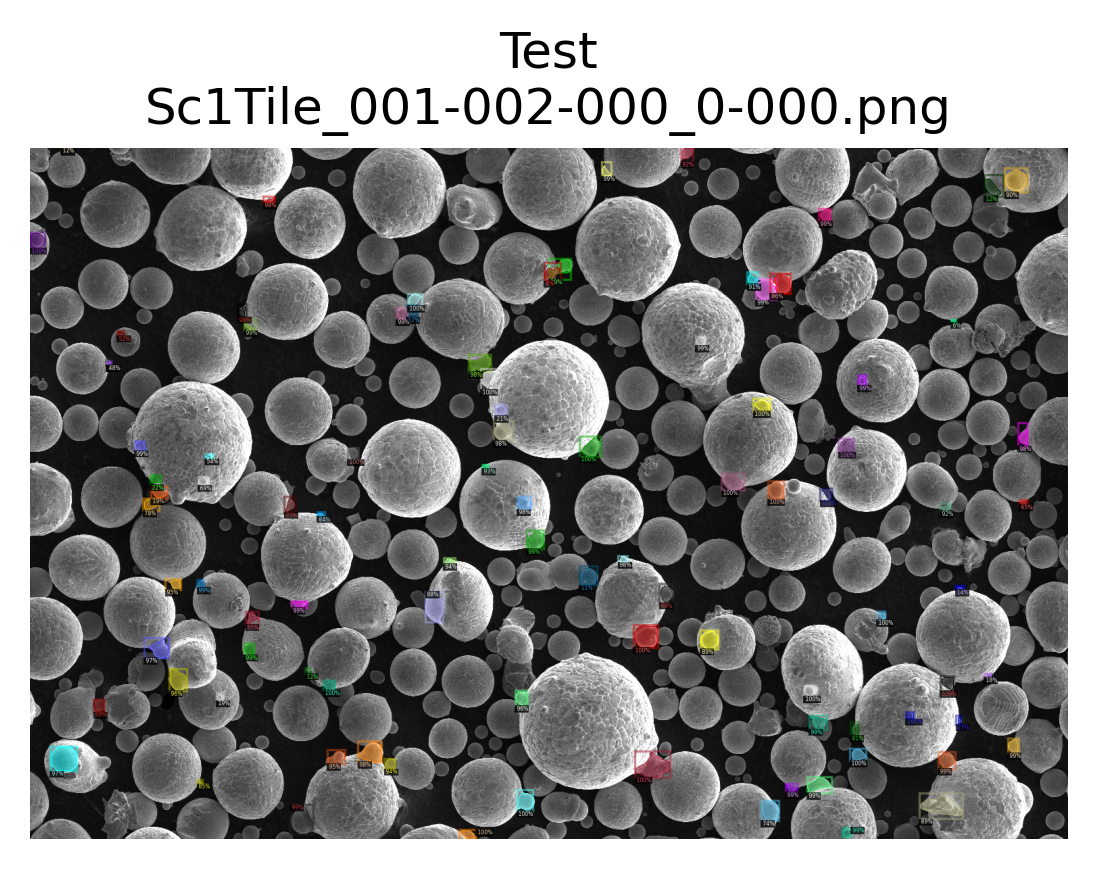

In [21]:
outs = predictor(img)
data_utils.format_outputs(img_path, dataset='test', pred=outs)
visualize.display_ddicts(ddict=outs,  # predictions to display
                                 outpath=None, dataset='Test',  # don't save fi$
                                 gt=False,  # specifies format as model predict$
                                 img_path=img_path, # path to image
                                 suppress_labels=True, #hides class images
                                 summary=False)  #hides the end print statement